In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
from datetime import datetime

In [2]:
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

In [3]:
df = pd.read_csv("hotel_bookings.csv")
df = df.copy()
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Agent veya Company gibi bazı kategorik değişkenlerde kategorilerden biri olarak “NULL” sunulmaktadır. Bu eksik bir değer olarak değil, “uygulanamaz” olarak değerlendirilmelidir. Örneğin, bir rezervasyon "Acente", "NULL" olarak tanımlanırsa, rezervasyonun bir seyahat acentesinden gelmediği anlamına gelir.

In [5]:
df["agent"] = df["agent"].fillna("Not Applicable")
df["company"] = df["company"].fillna("Not Applicable")
df["children"] = df["children"].fillna(0)
df["country"] = df["country"].fillna("Unknown")

Aynı anda ebeveyn, çocuk ve bebek = 0 olanları kaldıralım. Çünkü müşteri olmadığı anlamına gelir

In [6]:
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

aylar değişkenindeki object değerlerini kullanabileceğimiz formata çeviriyoruz

In [7]:
df['arrival_date_month'] = df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 
                                                             'May':5, 'June':6, 'July':7,'August':8, 
                                                             'September':9, 'October':10, 'November':11,'December':12})

ay yıl ve gün bilgilerini tek bir tarih formatında birleştiriyoruz

In [8]:
df['arrival_date'] = df['arrival_date_year'].map(str) + '-' + df['arrival_date_month'].map(str) + '-' \
                       + df['arrival_date_day_of_month'].map(str)

In [9]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,Not Applicable,Not Applicable,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,Not Applicable,Not Applicable,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,Not Applicable,Not Applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,304.0,Not Applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,240.0,Not Applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-7-1


In [10]:
df.shape

(119210, 33)

arrival_date ve reservation_status_date datetime formatına çeviriyoruz

In [11]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

Yetişkin çocuk ve bebek değiişkenlerinden toplam müşteriler olarak sayabileceğimiz türde yeni bir değişken oluşturuyoruz böylece otele gelen müşterileri tahminlemek daha kolay olabilir

In [12]:
df['Total Guests'] = df['adults'] + df['children'] + df["babies"]
df = df[df['Total Guests'] != 0]

Dinlenme tesisine gelenleri ve şehir otellerine gelenleri kendi gruplarında değerlendirebilmek için ayırıyoruz

In [13]:
#resort_otel = df[(df['hotel'] == 'Resort Hotel') & (df['is_canceled'] == 0)]
#city_otel = df[(df['hotel'] == 'City Hotel') & (df['is_canceled'] == 0)] 

resort_otel = df[df['hotel'] == 'Resort Hotel']
city_otel = df[df['hotel'] == 'City Hotel'] 

df = df.reset_index(drop=True)

In [14]:
df.shape

(119210, 34)

### Resort Otel

In [15]:
arrival_date_resort = resort_otel.iloc[: ,32:33]
total_guests_resort = resort_otel.iloc[: , 33:]

In [16]:
arrival_date_resort.reset_index(drop=True, inplace=True)
total_guests_resort.reset_index(drop=True, inplace=True)

resort_otel_data = pd.concat( [arrival_date_resort, total_guests_resort], axis=1) 

In [17]:
resort_otel_data.head()

,arrival_date,Total Guests
0,2015-07-01,2.0
1,2015-07-01,2.0
2,2015-07-01,1.0
3,2015-07-01,1.0
4,2015-07-01,2.0


In [18]:
#resort_otel_data = resort_otel_data.resample('m', on='arrival_date').sum()
resort_otel_data = resort_otel_data.resample('w', on='arrival_date').sum()
#resort_otel_data = resort_otel_data.resample('D', on='arrival_date').sum()

resort_otel_data

,Total Guests
arrival_date,
2015-07-05,471.0
2015-07-12,614.0
2015-07-19,732.0
2015-07-26,705.0
2015-08-02,781.0
...,...
2017-08-06,1061.0
2017-08-13,882.0
2017-08-20,1058.0


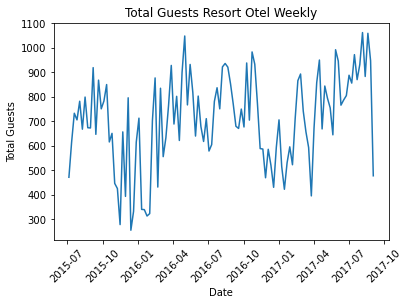

In [19]:
plt.xlabel("Date")
plt.ylabel("Total Guests")
plt.title("Total Guests Resort Otel Weekly")
plt.xticks(rotation=45)
plt.plot(resort_otel_data)

Rolling Statistics

In [20]:
rol_mean_r = resort_otel_data.rolling(window=12).mean()

rol_std_r = resort_otel_data.rolling(window=12).std()

print(rol_mean_r)
print(rol_std_r)

              Total Guests
arrival_date              
2015-07-05             NaN
2015-07-12             NaN
2015-07-19             NaN
2015-07-26             NaN
2015-08-02             NaN
...                    ...
2017-08-06      875.750000
2017-08-13      895.583333
2017-08-20      901.166667
2017-08-27      901.250000
2017-09-03      877.250000

[114 rows x 1 columns]
              Total Guests
arrival_date              
2015-07-05             NaN
2015-07-12             NaN
2015-07-19             NaN
2015-07-26             NaN
2015-08-02             NaN
...                    ...
2017-08-06      114.534731
2017-08-13       88.374676
2017-08-20       96.677377
2017-08-27       96.719017
2017-09-03      152.974225

[114 rows x 1 columns]


Hareketli Ortalama, tanımlanmış genişlikte yuvarlanan bir pencerenin matematiksel ortalamasını yapıyor. window-width wisely'i akıllıca seçmelisiniz, büyük bir pencere boyutu seriyi aşırı düzgünleştirir. Mevsimsel süreye eşit veya daha büyük bir pencere boyutu, mevsimsel etkiyi etkin bir şekilde geçersiz kılacaktır.

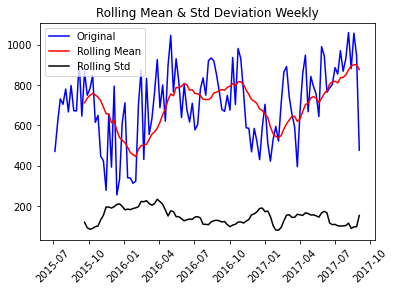

In [21]:
original = plt.plot(resort_otel_data , color = "blue" , label = "Original")
mean = plt.plot(rol_mean_r , color = "red" , label = "Rolling Mean")
std = plt.plot(rol_std_r , color = "black" , label = "Rolling Std")
plt.legend(loc = 'best')
plt.xticks(rotation = 45);
plt.title("Rolling Mean & Std Deviation Weekly")
plt.show(block = False)

In [22]:
print('Dickey-Fuller Test Sonuçları:')

dftest = adfuller(resort_otel_data["Total Guests"] , autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4] , index = ['Test Istatistics', 'p-value' , '#Lags Used' , 'Number of Observations Used'])
for key , value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key ] = value
    
print(dfoutput)

Dickey-Fuller Test Sonuçları:
Test Istatistics                -4.166506
p-value                          0.000750
#Lags Used                       1.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


### City Otel

In [23]:
arrival_date_city = city_otel.iloc[: ,32:33]
total_guests_city = city_otel.iloc[: , 33:]

In [24]:
arrival_date_city.reset_index(drop=True, inplace=True)
total_guests_city.reset_index(drop=True, inplace=True)

city_otel_data = pd.concat( [arrival_date_city, total_guests_city], axis=1) 

In [25]:
city_otel_data.head()

,arrival_date,Total Guests
0,2015-07-01,1.0
1,2015-07-01,2.0
2,2015-07-01,1.0
3,2015-07-01,2.0
4,2015-07-02,2.0


In [26]:
#city_otel_data = city_otel_data.resample('m', on='arrival_date').sum()
city_otel_data = city_otel_data.resample('w', on='arrival_date').sum()
#city_otel_data = city_otel_data.resample('D', on='arrival_date').sum()


city_otel_data

,Total Guests
arrival_date,
2015-07-05,354.0
2015-07-12,441.0
2015-07-19,646.0
2015-07-26,876.0
2015-08-02,446.0
...,...
2017-08-06,1584.0
2017-08-13,1623.0
2017-08-20,1802.0


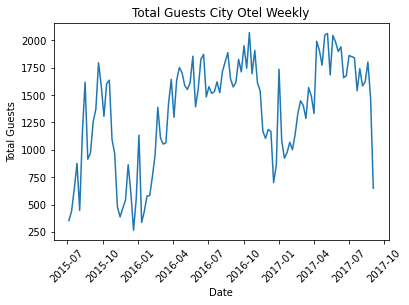

In [27]:
plt.xlabel("Date")
plt.ylabel("Total Guests")
plt.title("Total Guests City Otel Weekly")
plt.xticks(rotation=45)
plt.plot(city_otel_data)

Rolling Statistics

In [28]:
rol_mean_c = city_otel_data.rolling(window=12).mean()

rol_std_c = city_otel_data.rolling(window=12).std()

print(rol_mean_c)
print(rol_std_c)

              Total Guests
arrival_date              
2015-07-05             NaN
2015-07-12             NaN
2015-07-19             NaN
2015-07-26             NaN
2015-08-02             NaN
...                    ...
2017-08-06     1801.916667
2017-08-13     1766.750000
2017-08-20     1751.500000
2017-08-27     1716.250000
2017-09-03     1608.583333

[114 rows x 1 columns]
              Total Guests
arrival_date              
2015-07-05             NaN
2015-07-12             NaN
2015-07-19             NaN
2015-07-26             NaN
2015-08-02             NaN
...                    ...
2017-08-06      160.929944
2017-08-13      148.619175
2017-08-20      132.727677
2017-08-27      145.808794
2017-09-03      327.978231

[114 rows x 1 columns]


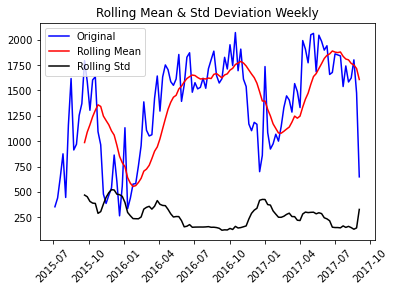

In [29]:
original = plt.plot(city_otel_data , color = "blue" , label = "Original")
mean = plt.plot(rol_mean_c , color = "red" , label = "Rolling Mean")
std = plt.plot(rol_std_c , color = "black" , label = "Rolling Std")
plt.legend(loc = 'best')
plt.xticks(rotation = 45);
plt.title("Rolling Mean & Std Deviation Weekly")
plt.show(block = False)

In [30]:
print('Dickey-Fuller Test Sonuçları:')

dftest = adfuller(city_otel_data["Total Guests"] , autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4] , index = ['Test Istatistics', 'p-value' , '#Lags Used' , 'Number of Observations Used'])
for key , value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key ] = value
    
print(dfoutput)

Dickey-Fuller Test Sonuçları:
Test Istatistics                -2.410778
p-value                          0.138718
#Lags Used                       2.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


ADF testi, zaman serisinin birim köke sahip olduğu ve durağan olmadığı sıfır hipotezinin olduğu, serilerin Durağanlık testinin en yaygın olarak kullanılan testidir. Dolayısıyla, ADH testindeki p-Değeri anlamlılık düzeyinden (0.05) küçükse, boş hipotezi reddederiz.
Sıfır Hipotezi : Serinin birim kökü vardır (a=1 değeri)
Alternatif Hipotez : Serinin birim kökü yoktur.

#### Resort & City Otel

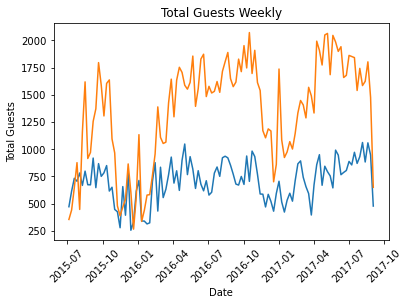

In [31]:
plt.xlabel("Date")
plt.ylabel("Total Guests")
plt.title("Total Guests Weekly")
plt.xticks(rotation=45)
plt.plot(resort_otel_data)
plt.plot(city_otel_data)

In [32]:
print('Dickey-Fuller Test Sonuçları Genel')

dftest = adfuller(df["Total Guests"] , autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4] , index = ['Test Istatistics', 'p-value' , '#Lags Used' , 'Number of Observations Used'])
for key , value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key ] = value
    
print(dfoutput)

Dickey-Fuller Test Sonuçları Genel
Test Istatistics                  -22.539780
p-value                             0.000000
#Lags Used                         67.000000
Number of Observations Used    119142.000000
Critical Value (1%)                -3.430405
Critical Value (5%)                -2.861564
Critical Value (10%)               -2.566783
dtype: float64


In [33]:
def test_stationarity(timeseries):
    rol_mean = timeseries.rolling(window=12).mean()
    rol_std  = timeseries.rolling(window=12).std()
    
    original = plt.plot(timeseries , color = "blue" , label = "Original")
    mean = plt.plot(rol_mean , color = "red" , label = "Rolling Mean")
    std = plt.plot(rol_std , color = "black" , label = "Rolling Std")
    plt.legend(loc = 'best')
    plt.xticks(rotation = 45);
    plt.title("Rolling Mean & Std Deviation ")
    plt.show(block = False)
    
    print('Dickey-Fuller Test Sonuçları ')
    dftest = adfuller(timeseries , autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4] , index = ['Test Istatistics', 'p-value' , '#Lags Used' , 'Number of Observations Used'])
    for key , value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key ] = value
    print(dfoutput)


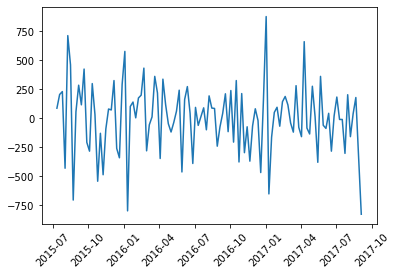

In [34]:
diff = city_otel_data["Total Guests"].diff()
plt.xticks(rotation=45)
plt.plot(diff)
plt.show()

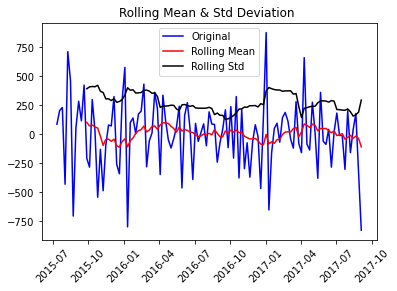

Dickey-Fuller Test Sonuçları 
Test Istatistics              -1.114804e+01
p-value                        2.991737e-20
#Lags Used                     1.000000e+00
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64


In [35]:
diff.dropna(inplace=True)
test_stationarity(diff)

Differencing — Fark alma, seriyi durağan hale getirmek ve otokorelasyonları kontrol etmek için kullanılır. Zaman serisi analizlerinde fark alınmasına ihtiyaç duymadığımız bazı durumlar olabilir ve aşırı fark verilmiş seriler yanlış tahmin üretebilir.

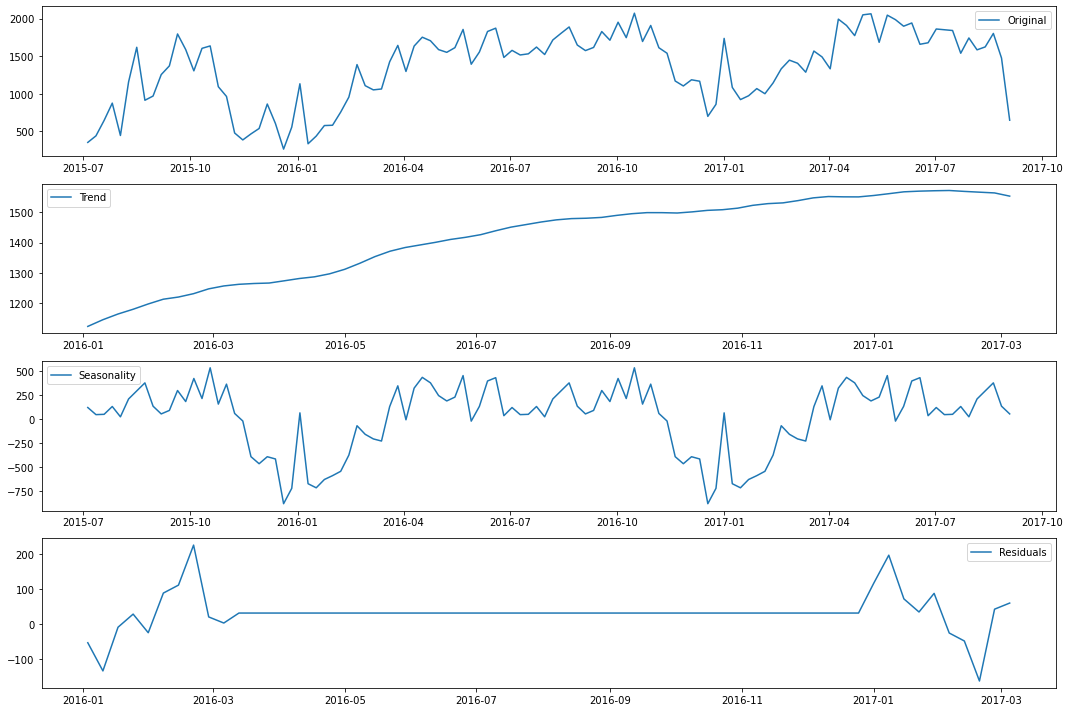

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(city_otel_data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid 

plt.figure(figsize=(15,10))

plt.subplot(411)
plt.plot(city_otel_data , label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend , label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal , label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual , label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

ETS Decomposition — ETS Decomposition, bir zaman serisinin farklı bileşenlerini ayırmak için kullanılır.

Aşağıdaki sol grafik KDE kalıntılarını göstermektedir. Çekirdek Yoğunluğu Tahmini ( KDE ), rastgele bir değişkenin olasılık yoğunluk fonksiyonunu (PDF) tahmin etmenin parametrik olmayan bir yoludur. Bu işlev Gauss çekirdeklerini kullanır ve otomatik bant genişliği belirlemeyi içerir.

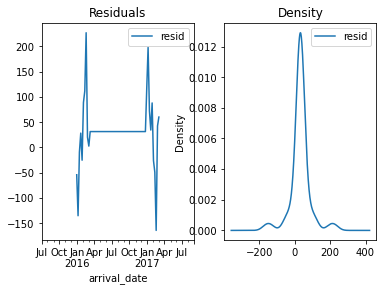

In [37]:
residuals = pd.DataFrame(decomposition.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Gerçek Değerler = Toplama (Mevsimsellik + Trend + Kalıntı)

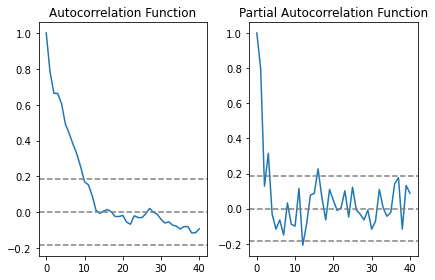

In [38]:
#ACF & PACF
from statsmodels.tsa.stattools import acf , pacf

lag_acf = acf(city_otel_data["Total Guests"] , nlags=40)
lag_pacf = pacf(city_otel_data["Total Guests"] , nlags=40 , method = 'ols')

#acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0 , linestyle='--' , color = 'gray')
plt.axhline(y = -1.96 / np.sqrt(len(city_otel_data["Total Guests"])) , linestyle = '--' , color = 'gray')
plt.axhline(y = 1.96 / np.sqrt(len(city_otel_data["Total Guests"])) , linestyle = '--' , color = 'gray')
plt.title('Autocorrelation Function')

#pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0 , linestyle='--' , color = 'gray')
plt.axhline(y = -1.96 / np.sqrt(len(city_otel_data["Total Guests"])) , linestyle = '--' , color = 'gray')
plt.axhline(y = 1.96 / np.sqrt(len(city_otel_data["Total Guests"])) , linestyle = '--' , color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Mehmet_DELIOGLU\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


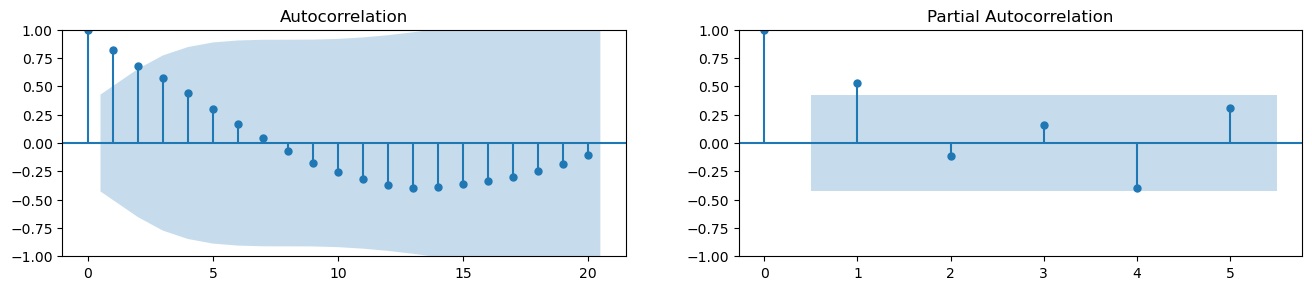

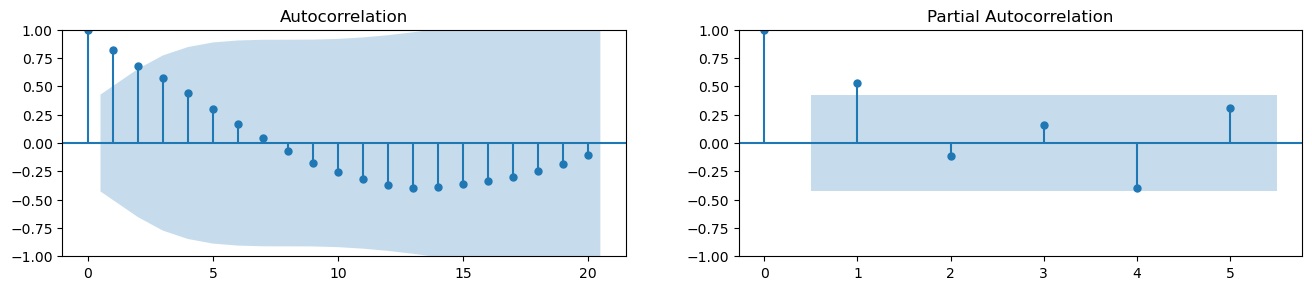

In [39]:
acf = acf(city_otel_data["Total Guests"], nlags=20)
pacf = pacf(city_otel_data["Total Guests"], nlags=20)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(acf, lags=20, ax=axes[0])
plot_pacf(pacf, lags=5, ax=axes[1])

Otokorelasyon önemlidir çünkü zaman serimizdeki kalıpları keşfetmemize, en iyi modelleme algoritmasını başarılı bir şekilde seçmemize, modelimizin etkinliğini doğru bir şekilde değerlendirmemize yardımcı olabilir. Spesifik olarak, otokorelasyon ve kısmi otokorelasyon grafikleri, önceki zaman adımlarındaki gözlemlerle bir zaman serisindeki gözlemler içindeki gücü ve ilişkiyi özetlemek için yoğun bir şekilde kullanılır.
Güçlü bir mevsimsel model olduğunda, ACF grafiğinde, mevsimsel pencerenin katlarında genellikle tanımlanan tekrarlanan artışları görebiliriz

Gecikmeler (lags): Bu dikkate alınan zaman aralığının değeridir ve gecikme olarak adlandırılır. Daha genel olarak, bir gecikme k otokorelasyonu, birbirinden k zaman periyodu olan değerler arasındaki korelasyondur.

ACF: ACF, gecikmeli değerleriyle herhangi bir serinin otomatik korelasyon değerlerini bize veren (tam) bir otomatik korelasyon işlevidir. Basit bir ifadeyle, serinin şimdiki değerinin geçmiş değerleriyle ne kadar iyi ilişkili olduğunu açıklar. Bir zaman serisi, trend, mevsimsellik, döngüsel ve kalıntı gibi bileşenlere sahip olabilir. ACF, korelasyonları bulurken tüm bu bileşenleri dikkate alır, dolayısıyla bu bir ‘tam otomatik korelasyon grafiği’dir.

PACF: PACF, kısmi bir otomatik korelasyon işlevidir. Adından da anlaşılacağı gibi, PACF, ACF’nin bir alt kümesidir. PACF, diğer veri noktalarından herhangi bir etkiyi hesaba katarken, zaman içinde iki noktada yapılan gözlemler arasındaki korelasyonu ifade eder. AR modelinde kullanılacak optimal terim sayısını belirlemek için PACF’yi kullanabiliriz. Terim sayısı modelin sırasını belirler. Bir AR modelinin tanımlanması genellikle en iyi PACF ile yapılır.

In [40]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [41]:
stepwise_fit = auto_arima(city_otel_data["Total Guests"] , start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1493.381, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1475.532, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1491.543, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1467.773, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1472.317, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1462.096, Time=1.00 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1472.725, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1463.892, Time=1.11 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1463.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  114
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -726.048
Date:                            Mon, 11 Apr 2022   AIC                           1462.096
Time:                                    22:06:47   BIC                           1475.171
Sample:                                         0   HQIC                          1467.389
                                            - 114                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3577      0.113     -3.167      0.002      -0.579      -0.136
ar.L2         -0.2888      0.120     -2.415      0.016      -0.523      -0.054
ar.S.L12      -0.6804      0.123     -5.541      0.000      -0.921      -0.440
ar.S.L24      -0.4422      0.122     -3.627      0.000      -0.681      -0.203
sigma2      9.652e+04   1.35e+04      7.164      0.000    7.01e+04    1.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.58
Prob(Q):                              0.96   Prob(JB):                         0.06
Heteroskedasticity (H):               0.66   Skew:                            -0.31
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Standart ARIMA modelleri, giriş parametreleri olarak 3 bağımsız değişken, yani p,d,q bekler.
p gecikme gözlemlerinin sayısıdır.
d fark derecesidir.
q, hareketli ortalama penceresinin boyutu/genişliğidir.

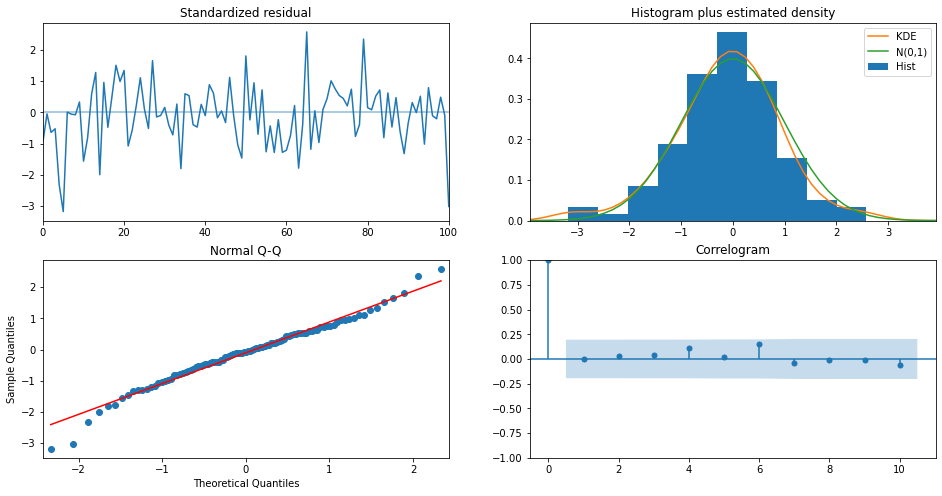

In [42]:
stepwise_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Standardized Residual: Standartlaştırılmış artık, gözlemlenen ve beklenen değerler arasındaki farkın gücünün bir ölçüsüdür.

Normal Q-Q : QQ grafiği veya nicel-kantil grafiği, bir dizi verinin Normal veya üstel gibi bazı teorik dağılımlardan makul bir şekilde gelip gelmediğini değerlendirmemize yardımcı olan bir grafik araçtır. Örneğin, bağımlı değişkenimizin Normal dağıldığını varsayan bir istatistiksel analiz çalıştırırsak, bu varsayımı kontrol etmek için Normal QQ grafiğini kullanabiliriz. Bu sadece görsel bir kontrol, hava geçirmez bir kanıt değil, bu yüzden biraz öznel. Ancak, varsayımımızın makul olup olmadığını ve değilse, varsayımın nasıl ihlal edildiğini ve hangi veri noktalarının ihlale katkıda bulunduğunu bir bakışta görmemizi sağlar.

Bir QQ grafiği, birbirine karşı iki nicelik kümesi çizilerek oluşturulan bir dağılım grafiğidir. Her iki kuantil grubu da aynı dağılımdan geldiyse, noktaların kabaca düz bir çizgi oluşturduğunu görmeliyiz.

Correlogram : Zamanla değişen verilerdeki (yani zaman serisi verileri) seri korelasyonu göstermenin görsel bir yoludur . Seri korelasyon ( otokorelasyon olarak da adlandırılır ), zamanın bir noktasındaki bir hatanın bir sonraki zaman noktasına seyahat etmesidir.

In [43]:
print(city_otel_data.shape)
train = city_otel_data.iloc[:85]
test  = city_otel_data.iloc[85:] 
print(train.shape , test.shape)

(114, 1)
(85, 1) (29, 1)


In [44]:
model = ARIMA(train["Total Guests"] , order = (1,0,1) , seasonal_order=(2,1,0,12))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      Total Guests   No. Observations:                   85
Model:             ARIMA(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -525.798
Date:                           Mon, 11 Apr 2022   AIC                           1061.595
Time:                                   22:06:50   BIC                           1073.048
Sample:                               07-05-2015   HQIC                          1066.159
                                    - 02-12-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9203      0.057     16.253      0.000       0.809       1.031
ma.L1         -0.3259      0.114     -2.868      0.004      -0.549      -0.103
ar.S.L12      -0.6136      0.186     -3.293      0.001      -0.979      -0.248
ar.S.L24      -0.2845      0.169     -1.682      0.093      -0.616       0.047
sigma2      1.015e+05    1.8e+04      5.628      0.000    6.61e+04    1.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.60
Prob(Q):                              0.86   Prob(JB):                         0.45
Heteroskedasticity (H):               0.78   Skew:                            -0.24
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
start = len(train)
end = len(train) + len(test)-1
pred = model.predict(start = start , end = end , dynamic=False , type = 'levels')
#pred.index = city_otel_data.index[start:end+1]
print(pred)

2017-02-19    1107.022116
2017-02-26    1193.534743
2017-03-05    1171.200744
2017-03-12    1003.760100
2017-03-19    1149.102590
2017-03-26    1444.845294
2017-04-02    1344.658230
2017-04-09    1147.459044
2017-04-16    1308.101813
2017-04-23    1287.088342
2017-04-30    1274.459967
2017-05-07    1152.424223
2017-05-14    1106.794341
2017-05-21    1189.680219
2017-05-28    1244.499261
2017-06-04    1002.295968
2017-06-11    1187.305243
2017-06-18    1539.130129
2017-06-25    1385.553838
2017-07-02    1155.471577
2017-07-09    1300.806165
2017-07-16    1245.168497
2017-07-23    1202.127054
2017-07-30    1101.655969
2017-08-06    1057.300734
2017-08-13    1145.013495
2017-08-20    1157.017402
2017-08-27     878.765914
2017-09-03    1046.634787
Freq: W-SUN, Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='arrival_date'>

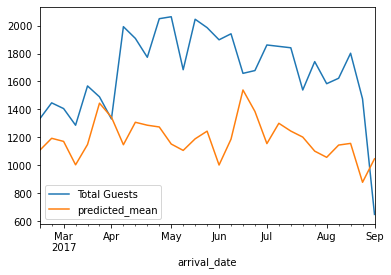

In [46]:
test["Total Guests"].plot(legend = True)
pred.plot(legend = True)

<AxesSubplot:xlabel='arrival_date'>

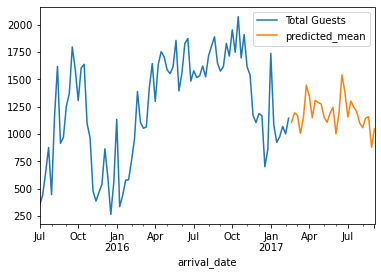

In [47]:
train["Total Guests"].plot(legend = True)
pred.plot(legend = True)

In [48]:
test["Total Guests"].mean()

1672.5172413793102

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred , test["Total Guests"]))
print(rmse)

568.2332031011413


Bir makine öğrenmesi modelinin, tahminleyicinin tahmin ettiği değerler ile gerçek değerleri arasındaki uzaklığın bulunmasında sıklıkla kullanılan, hatanın büyüklğünü ölçen kuadratik bir metriktir. RMSE tahmin hatalarının (kalıntıların) standart sapmasıdır. Yani, kalıntılar, regresyon hattının veri noktalarından ne kadar uzakta olduğunun bir ölçüsüdür; RMSE ise bu kalıntıların ne kadar yayıldığının bir ölçüsüdür. Başka bir deyişle, verilere en iyi uyan çizgi etrafında o verilerin ne kadar yoğun olduğunu söyler. RMSE değeri 0’dan ∞’a kadar değişebilir. Negatif yönelimli puanlar yani daha düşük değerlere sahip tahminleyiciler daha iyi performans gösterir. RMSE değerinin sıfır olması modelin hiç hata yapmadığı anlamına gelir. RMSE, büyük hataları daha fazla cezalandırmanın avantajına sahiptir, bu yüzden bazı durumlara daha uygun olabilir.

In [55]:
model2 = ARIMA(city_otel_data["Total Guests"] , order = (1,0,1) , seasonal_order=(2,1,0,12))
model2 = model2.fit()

Son gün değerinden sonra beklenen tahmini 30 günlük gelecek müşteri sayısı

In [56]:
index_future_dataset = pd.date_range(start = "2017-09-03" ,  end = "2017-10-03")

pred = model2.predict(start = len(train) , end=len(train)+30 , type='levels').rename("ARIMA Predictions")

pred.index = index_future_dataset

<AxesSubplot:>

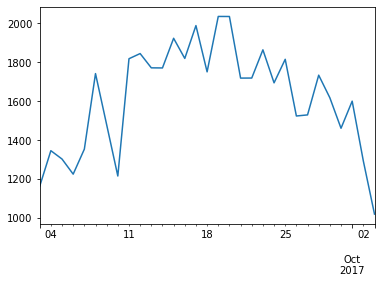

In [57]:
pred.plot()